# Metrics Lab

This notebook contains functions to compute hierarchical metrics for HIS

- [Utils](#utils)
- [Hierarchical entropy](#hierarchical-entropy)
- [Metrics](#metrics)
    - Hierarchical Precision
    - Hierarchical Recall
    - Hierarchical F1-score

# Lab


In [1]:
import numpy as np
from typing import List, Tuple, Callable
import pickle
import matplotlib.pyplot as plt
import itertools

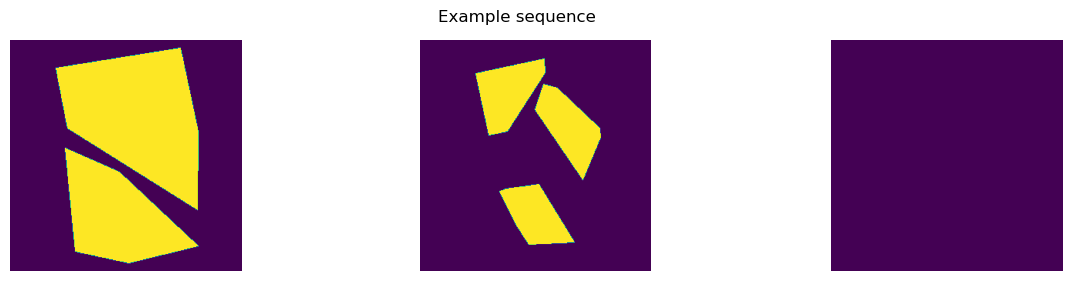

In [2]:
# example input
with open("../data/DPoly_plain_1000/RCNNAnnotations/4.pkl", "rb") as file:
    example = pickle.load(file)
    example = [(mask>=1).astype(int) for mask in example]
    
    
# plot the example sequence
plt.figure(figsize=(15, 3))
for i in range(len(example)):
    plt.subplot(1, len(example), i+1)
    plt.imshow(example[i])
    plt.axis("off")

plt.suptitle("Example sequence");

## Image to Tree - Recurrent Output Adaptor

In [3]:
def find_seed(matrix: np.ndarray) -> Tuple[int, int]:
    """finds first non-zero entry in the matrix

    Args:
        matrix (np.ndarray): 2-D matrix of binary non overlapping regions

    Returns:
        Tuple[int, int]: index of first non-zero entry
    """
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] == 1:
                return i, j

In [4]:
def flood(mask: np.ndarray, 
          seed_x: int,
          seed_y: int,
          value: int = 2) -> None:
    """flood fills the area for given seed

    Args:
        mask (np.ndarray): 2-D matrix with regions
        seed_x (int): x index of seed
        seed_y (int): y index of seed
        value (int, optional): fill value. Defaults to 2.
    """
    flood_area = mask[seed_x, seed_y]
    fill_pixels = [(seed_x, seed_y)]
    
    def is_valid(i, j):
        return (i >= 0
                and j >= 0
                and i < mask.shape[0]
                and j < mask.shape[1])
    
    while fill_pixels:
        x, y = fill_pixels.pop()
        mask[x, y] = value
        
        for dx, dy in itertools.product([0,1,-1], [0, 1, -1]):
            if is_valid(x+dx, y+dy) and mask[x+dx, y+dy] == flood_area:
                fill_pixels.append((x+dx, y+dy))
                    

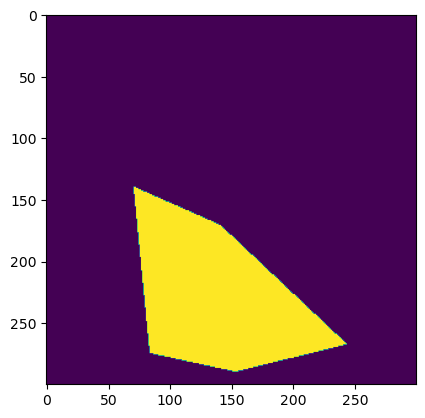

In [5]:
def test():
    trial = example[0].copy()
    flood(trial, 250, 100, 400)
    plt.imshow(trial)
    
test()

In [6]:
def flood_fill(mask: np.ndarray) -> int:
    index = find_seed(mask)
    mask_counter = 2
    while index:
        flood(mask, index[0], index[1], mask_counter)
        index = find_seed(mask)
        mask_counter += 1
        
    return mask, mask_counter-2

In [7]:
def binary_mask_to_children(mask: np.ndarray) -> List[np.ndarray]:
    """Converts a compund binary mask to list of individual masks

    Args:
        mask (torch.tensor): binary mask of objects
    """
    
    mask, n_children = flood_fill(mask.copy())
        
    children = []
    for i in range(n_children):
        children.append(mask == i+2)
        
    return children

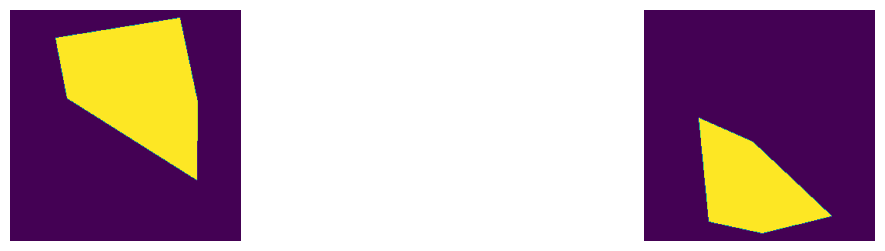

In [8]:
def test():
    trial = example[0].copy()
    trial[trial >= 1] = 1
    children = binary_mask_to_children(trial)
    plt.figure(figsize=(15, 3))
    for i in range(len(children)):
        plt.subplot(1, len(children), i+1)
        plt.imshow(children[i])
        plt.axis("off")
        
test()

## Tree utils

- Hierarchical Entropy

In [9]:
class Tree:
    def __init__(self, data, level=0):
        self.data = data
        self.level = level
        self.entropy = 1
        self.children: List[Tree] = []
        self.match = None
        
    def traverse_inorder(self, func: Callable=lambda x, l: print("  "*l, x.data)):
        func(self, self.level)
        for child in self.children:
            child.traverse_inorder(func)
            
    def _assign_r_entropy(self, entropy=1):
        self.entropy = (2*entropy)/(len(self.children)+2) if len(self.children) else entropy
        for child in self.children:
            child._assign_r_entropy(entropy/(len(self.children)+2))
            
    def assign_entropy(self):
        self._assign_r_entropy()
        def reciprocal(x, l):
            x.entropy = 1/x.entropy
            
        self.traverse_inorder(reciprocal)
        
    def total_entropy(self):
        total = 0
        def get_total(x, l):
            nonlocal total
            total += x.entropy
            
        self.traverse_inorder(get_total)
        return total
    
    def copy(self):
        root = Tree(self.data, self.level)
        
        for child in self.children:
            root.children.append(child.copy())
        
        return root
    
    def find_matching(self, masks: np.ndarray, threshold=0.9) -> "Tree":
        tree = self.copy()
        
        def matcher(x, l):
            for m in masks:
                if np.sum(x.data & m) / np.sum(x.data | m) >= threshold:
                    x.match = True
                    
        tree.traverse_inorder(matcher)
        return tree
    
    def _flat_list(self) -> List["Tree"]:
        children = []
        for child in self.children:
            if child.match == True:
                children.append(child)
            else:
                children.extend(child._flat_list())
                
        return children
        
        
    def prune(self, level=0):
        root = Tree(self.data, level)
        children = self._flat_list()
        
        for child in children:
            root.children.append(child.prune(level+1))
            
        return root
        
    

In [10]:
def test():
    tree = Tree(0)
    c1 = Tree(1, 1)
    c2 = Tree(2, 1)
    c1_1 = Tree(3, 2)
    c1_2 = Tree(4, 2)
    c1_3 = Tree(5, 2)
    
    c1.children = [c1_1, c1_2, c1_3]
    tree.children = [c1, c2]
    
    tree.traverse_inorder()
    tree.assign_entropy()
    # tree.traverse_inorder(lambda x, l: print(" "*l, x.entropy, ":", x.data))
    print(tree.total_entropy())
    
    n_tree = tree.copy()
    n_tree.traverse_inorder(lambda x, l: print("  "*l, x.data))
    
test()

 0
   1
     3
     4
     5
   2
76.0
 0
   1
     3
     4
     5
   2


In [11]:
def is_contained(parent: np.ndarray, child: np.ndarray):
    return np.all((parent & child) == child)

In [12]:
def _generate_tree(root: Tree, mask_groups: dict):
    if root.level + 1 > len(mask_groups):
        return
    
    for mask in mask_groups[root.level+1]:
        if is_contained(root.data, mask):
            root.children.append(Tree(mask, root.level+1))
            
    for child in root.children:
        _generate_tree(child, mask_groups)

In [13]:
def generate_mask_tree(masks: List[np.ndarray]) -> Tree:
    root = Tree(np.ones(masks[0].shape, dtype=bool))
    mask_groups = {i+1: binary_mask_to_children(mask) for i, mask in enumerate(masks)}
    
    # generate mask hierarchy tree
    _generate_tree(root, mask_groups)
    
    return root

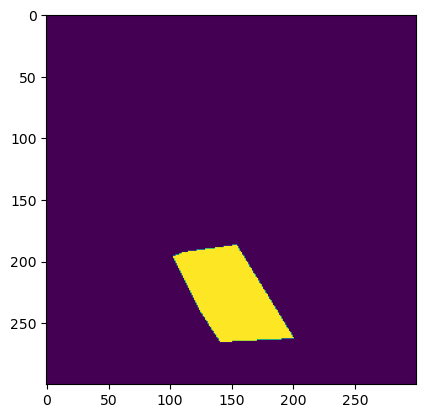

In [14]:
tree = generate_mask_tree(example)
plt.imshow(tree.children[1].children[0].data)

In [15]:
tree.traverse_inorder(lambda x, l: print(" "*l, "l"))

 l
  l
   l
   l
  l
   l


# Metrics
- Matching nodes
    - skeletal tree

In [16]:
def get_mask_list(masks: List[np.ndarray]) -> List[np.ndarray]:
    mask_list = []
    for mask in masks:
        mask_list.extend(binary_mask_to_children(mask))
        
    return mask_list

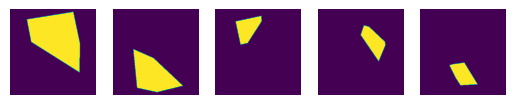

In [17]:
example_list = get_mask_list(example)
for i in range(len(example_list)):
    plt.subplot(1, len(example_list), i+1)
    plt.imshow(example_list[i])
    plt.axis("off")

In [18]:
def IoU(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """Intersection over Union score for two masks

    Args:
        mask1 (np.ndarray): first input mask
        mask2 (np.ndarray): second input mask

    Returns:
        float: iou score
    """
    return (mask1 & mask2) / (mask1 | mask2)

In [19]:
def hierarchical_metrics(truth: List[np.ndarray], pred: List[np.ndarray]) -> dict:
    
    # ground truth tree
    gt_tree = generate_mask_tree(truth)
    
    # prediction list
    pred_tree = generate_mask_tree(pred)
    preds = get_mask_list(pred)
    
    # get matching tree
    pruned_tree = gt_tree.find_matching(preds).prune()
    
    # assign entropy
    gt_tree.assign_entropy()
    pred_tree.assign_entropy()
    pruned_tree.assign_entropy()
    
    gt_tree.traverse_inorder(lambda x, l: print("  "*l, x.entropy))
    pred_tree.traverse_inorder(lambda x, l: print("  "*l, x.entropy))
    pruned_tree.traverse_inorder(lambda x, l: print("  "*l, x.entropy))
    
    # compute entropy
    gt_e = gt_tree.total_entropy()
    pred_e = pred_tree.total_entropy()
    pruned_e = pruned_tree.total_entropy()
    
    # precision, recall , f1
    precision = pruned_e / pred_e
    recall = pruned_e / gt_e
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return {
        "hierarchical-precision": precision,
        "hierarchical-recall": recall,
        "heirarchical-f1": f1
    }

In [20]:
def test():
    print(hierarchical_metrics(example, example[1:]))
    
test()

3 2
 2.0
   8.0
     16.0
     16.0
   6.0
     12.0
 2.5
   5.0
   5.0
   5.0
 2.5
   5.0
   5.0
   5.0
60.0 17.5 17.5
{'hierarchical-precision': 1.0, 'hierarchical-recall': 0.2916666666666667, 'heirarchical-f1': 0.45161290322580644}


In [21]:
def test():
    # tree.traverse_inorder()

    examples = example_list[0:2:]
    
    new_tree = tree.find_matching(examples)
    
    pruned_tree = new_tree.prune()
    
    pruned_tree.traverse_inorder(lambda x, l: print("  "*l, ":", x.match))
        
    
    
test()

 : None
   : None
   : None


In [22]:
def test():
    tree = Tree(1)
    c1 = Tree(1, 1)
    c2 = Tree(1, 1)
    c1_1 = Tree(1, 2)
    c1_2 = Tree(1, 2)
    c1_3 = Tree(1, 2)
    c2_1 = Tree(1, 2)
    
    c1.children = [c1_1, c1_2, c1_3]
    c2.children = [c2_1]
    tree.children = [c1, c2]
    
    tree2 = Tree(1)
    c1 = Tree(1, 1)
    c2 = Tree(1, 1)
    c1_1 = Tree(1, 2)
    c1_2 = Tree(1, 2)
    c1_3 = Tree(1, 2)
    c2_1 = Tree(1, 2)
    
    c1.children = [c1_1, c1_2, c1_3]
    c2.children = [c2_1]
    tree2.children = [c1, c2]
    
    

    
    
test()

 1
   1
     1
     1
     1
   1
     1
90.0
 1
   1
     1
     1
     1
   1
     1


# Utils